## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [56]:
import os
import keras
import itertools
from keras.layers import BatchNormalization
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [57]:
train, test = keras.datasets.cifar10.load_data()

In [58]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [59]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [60]:
Dense = keras.layers.Dense

In [61]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, 
                      activation="relu",
                      name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=n_units,
                      activation="relu",
                      name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    out = Dense(units=output_units,
                activation="softmax",
                name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
                
    return model

In [62]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [63]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau
#新的LEARNING_RATE會等於舊的LEARNING_RATE * factor
#min_lr LEARNING_RATE的下邊界

FACTOR = [0.1, 0.5, 0.8]
PATIENCE = [5, 10]

1.請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響

In [64]:
results = {}
for i in FACTOR:
    for j in PATIENCE:
        keras.backend.clear_session()
        name_tag = "factor=%s, patience=%s" % (i,j)
        print(name_tag)
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        reducce_lr = ReduceLROnPlateau(factor=i,
                                       min_lr=1e-12,
                                       monitor='val_loss',
                                       patience=j,
                                       verbose=1)
        
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[reducce_lr])

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
              
        results[name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

factor=0.1, patience=5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)             

50000/50000 [==============================] - 4s 85us/step - loss: 0.8605 - acc: 0.7183 - val_loss: 1.4613 - val_acc: 0.5044
Epoch 48/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.8596 - acc: 0.7201 - val_loss: 1.4613 - val_acc: 0.5045
Epoch 49/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.8605 - acc: 0.7199 - val_loss: 1.4613 - val_acc: 0.5045
Epoch 50/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.8594 - acc: 0.7209 - val_loss: 1.4613 - val_acc: 0.5045

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
factor=0.1, patience=10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________

50000/50000 [==============================] - 4s 85us/step - loss: 0.7189 - acc: 0.7779 - val_loss: 1.4766 - val_acc: 0.5086

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 45/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7155 - acc: 0.7784 - val_loss: 1.4772 - val_acc: 0.5074
Epoch 46/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7138 - acc: 0.7800 - val_loss: 1.4758 - val_acc: 0.5082
Epoch 47/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7110 - acc: 0.7810 - val_loss: 1.4762 - val_acc: 0.5062
Epoch 48/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7110 - acc: 0.7798 - val_loss: 1.4762 - val_acc: 0.5058
Epoch 49/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7111 - acc: 0.7810 - val_loss: 1.4767 - val_acc: 0.5058
Epoch 50/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7110 - acc: 0.7810 -

50000/50000 [==============================] - 4s 85us/step - loss: 0.7954 - acc: 0.7458 - val_loss: 1.4745 - val_acc: 0.5000
Epoch 41/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7935 - acc: 0.7456 - val_loss: 1.4782 - val_acc: 0.4999
Epoch 42/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7899 - acc: 0.7479 - val_loss: 1.4806 - val_acc: 0.5007

Epoch 00042: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 43/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7855 - acc: 0.7487 - val_loss: 1.4790 - val_acc: 0.5010
Epoch 44/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7827 - acc: 0.7518 - val_loss: 1.4783 - val_acc: 0.5000
Epoch 45/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.7816 - acc: 0.7524 - val_loss: 1.4791 - val_acc: 0.5009
Epoch 46/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7803 - acc: 0.7526 - v

50000/50000 [==============================] - 4s 84us/step - loss: 0.7635 - acc: 0.7562 - val_loss: 1.5212 - val_acc: 0.5028
Epoch 38/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7551 - acc: 0.7608 - val_loss: 1.5163 - val_acc: 0.5010
Epoch 39/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7431 - acc: 0.7653 - val_loss: 1.5214 - val_acc: 0.5006
Epoch 40/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7334 - acc: 0.7680 - val_loss: 1.5260 - val_acc: 0.5004

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 41/50
50000/50000 [==============================] - 4s 83us/step - loss: 0.7183 - acc: 0.7742 - val_loss: 1.5198 - val_acc: 0.4993
Epoch 42/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7085 - acc: 0.7796 - val_loss: 1.5255 - val_acc: 0.5009
Epoch 43/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7029 - acc: 0.7810 - 

50000/50000 [==============================] - 5s 91us/step - loss: 0.8259 - acc: 0.7304 - val_loss: 1.4763 - val_acc: 0.4939
Epoch 34/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.8127 - acc: 0.7350 - val_loss: 1.4774 - val_acc: 0.4940

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
Epoch 35/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.7962 - acc: 0.7404 - val_loss: 1.4849 - val_acc: 0.4930
Epoch 36/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.7845 - acc: 0.7470 - val_loss: 1.4825 - val_acc: 0.4967
Epoch 37/50
50000/50000 [==============================] - 4s 86us/step - loss: 0.7724 - acc: 0.7515 - val_loss: 1.4836 - val_acc: 0.4922
Epoch 38/50
50000/50000 [==============================] - 4s 86us/step - loss: 0.7638 - acc: 0.7540 - val_loss: 1.4957 - val_acc: 0.4932
Epoch 39/50
50000/50000 [==============================] - 4s 86us/step - loss: 0.7528 - acc: 0.7587 - 

50000/50000 [==============================] - 5s 90us/step - loss: 0.8743 - acc: 0.7106 - val_loss: 1.4822 - val_acc: 0.4894
Epoch 30/50
50000/50000 [==============================] - 4s 90us/step - loss: 0.8543 - acc: 0.7181 - val_loss: 1.4894 - val_acc: 0.4892
Epoch 31/50
50000/50000 [==============================] - 5s 90us/step - loss: 0.8368 - acc: 0.7270 - val_loss: 1.4967 - val_acc: 0.4856

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 32/50
50000/50000 [==============================] - 5s 90us/step - loss: 0.8138 - acc: 0.7353 - val_loss: 1.4914 - val_acc: 0.4915
Epoch 33/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.7947 - acc: 0.7440 - val_loss: 1.5069 - val_acc: 0.4934
Epoch 34/50
50000/50000 [==============================] - 5s 92us/step - loss: 0.7770 - acc: 0.7518 - val_loss: 1.5021 - val_acc: 0.4971
Epoch 35/50
50000/50000 [==============================] - 5s 92us/step - loss: 0.7620 - acc: 0.7568 - v

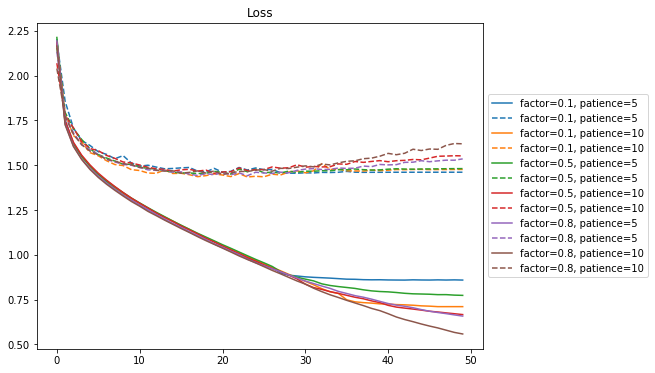

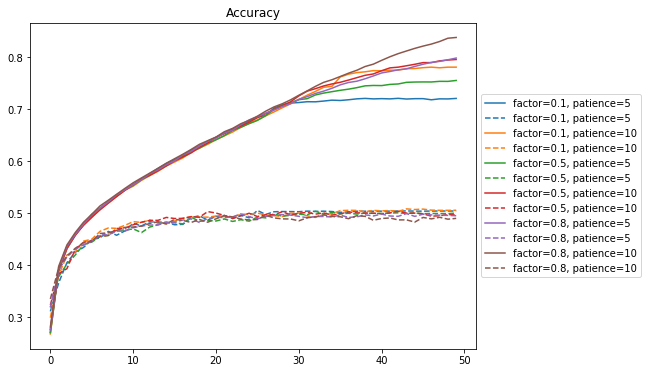

In [65]:
# 繪製結果
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

2.請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [66]:
results_adam = {}
for i in FACTOR:
    for j in PATIENCE:
        keras.backend.clear_session()
        name_tag = "factor=%s, patience=%s" % (i,j)
        print(name_tag)
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer_adam = keras.optimizers.Adam(lr=LEARNING_RATE)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer_adam)

        reducce_lr = ReduceLROnPlateau(factor=i,
                                       min_lr=1e-12,
                                       monitor='val_loss',
                                       patience=j,
                                       verbose=1)
        
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[reducce_lr])

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
              
        results_adam[name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

factor=0.1, patience=5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)             

50000/50000 [==============================] - 5s 101us/step - loss: 0.4564 - acc: 0.8692 - val_loss: 1.4310 - val_acc: 0.5499
Epoch 47/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.4558 - acc: 0.8699 - val_loss: 1.4310 - val_acc: 0.5498
Epoch 48/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.4561 - acc: 0.8691 - val_loss: 1.4310 - val_acc: 0.5498
Epoch 49/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.4561 - acc: 0.8687 - val_loss: 1.4310 - val_acc: 0.5496
Epoch 50/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.4559 - acc: 0.8685 - val_loss: 1.4311 - val_acc: 0.5495

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
factor=0.1, patience=10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
______________

50000/50000 [==============================] - 5s 100us/step - loss: 0.4663 - acc: 0.8676 - val_loss: 1.4626 - val_acc: 0.5350
Epoch 43/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.4661 - acc: 0.8664 - val_loss: 1.4628 - val_acc: 0.5347
Epoch 44/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.4659 - acc: 0.8676 - val_loss: 1.4629 - val_acc: 0.5350
Epoch 45/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.4649 - acc: 0.8674 - val_loss: 1.4631 - val_acc: 0.5355
Epoch 46/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.4652 - acc: 0.8681 - val_loss: 1.4632 - val_acc: 0.5354
Epoch 47/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.4651 - acc: 0.8678 - val_loss: 1.4634 - val_acc: 0.5352
Epoch 48/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.4650 - acc: 0.8679 - val_loss: 1.4638 - val_acc: 0.5348
Epoch 49/50
50000/50000 [==============

Epoch 37/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.2853 - acc: 0.9385 - val_loss: 1.6698 - val_acc: 0.5177
Epoch 38/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.2819 - acc: 0.9402 - val_loss: 1.6735 - val_acc: 0.5214

Epoch 00038: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 39/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.2760 - acc: 0.9419 - val_loss: 1.6759 - val_acc: 0.5211
Epoch 40/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.2737 - acc: 0.9436 - val_loss: 1.6778 - val_acc: 0.5198
Epoch 41/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.2720 - acc: 0.9447 - val_loss: 1.6872 - val_acc: 0.5208
Epoch 42/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.2707 - acc: 0.9441 - val_loss: 1.6855 - val_acc: 0.5207
Epoch 43/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.2

Epoch 33/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.1739 - acc: 0.9673 - val_loss: 1.8958 - val_acc: 0.5233
Epoch 34/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.1657 - acc: 0.9696 - val_loss: 1.9727 - val_acc: 0.5186
Epoch 35/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.1553 - acc: 0.9732 - val_loss: 1.9779 - val_acc: 0.5123
Epoch 36/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.1468 - acc: 0.9757 - val_loss: 1.9916 - val_acc: 0.5190
Epoch 37/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.1363 - acc: 0.9786 - val_loss: 2.0361 - val_acc: 0.5173
Epoch 38/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.1291 - acc: 0.9804 - val_loss: 2.0864 - val_acc: 0.5110
Epoch 39/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.1204 - acc: 0.9832 - val_loss: 2.1212 - val_acc: 0.5088
Epoch 40/50
50000/50000 [==

50000/50000 [==============================] - 5s 101us/step - loss: 0.3200 - acc: 0.9059 - val_loss: 1.9815 - val_acc: 0.4943

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.
Epoch 29/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.2826 - acc: 0.9204 - val_loss: 1.9497 - val_acc: 0.4820
Epoch 30/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.2535 - acc: 0.9339 - val_loss: 2.0136 - val_acc: 0.4990
Epoch 31/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.2343 - acc: 0.9409 - val_loss: 2.1109 - val_acc: 0.4895
Epoch 32/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.2173 - acc: 0.9465 - val_loss: 2.1131 - val_acc: 0.4846
Epoch 33/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.2024 - acc: 0.9509 - val_loss: 2.1132 - val_acc: 0.4988

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
Epoch 34/50
50

50000/50000 [==============================] - 5s 101us/step - loss: 0.5554 - acc: 0.8094 - val_loss: 2.1212 - val_acc: 0.4371

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 24/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.4770 - acc: 0.8426 - val_loss: 2.0171 - val_acc: 0.4286
Epoch 25/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.4333 - acc: 0.8607 - val_loss: 1.9791 - val_acc: 0.4518
Epoch 26/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.3991 - acc: 0.8705 - val_loss: 2.0210 - val_acc: 0.4713
Epoch 27/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.3801 - acc: 0.8771 - val_loss: 2.1059 - val_acc: 0.4597
Epoch 28/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.3530 - acc: 0.8877 - val_loss: 2.0394 - val_acc: 0.4763
Epoch 29/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.3296 - acc: 0.8

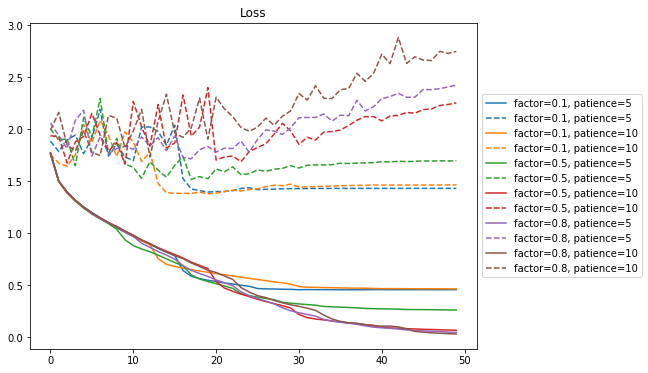

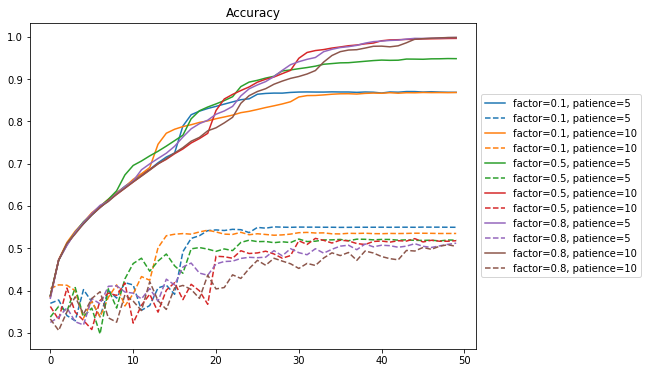

In [67]:
# 繪製結果
plt.figure(figsize=(8,6))
for i, cond in enumerate(results_adam.keys()):
    plt.plot(range(len(results_adam[cond]['train-loss'])),results_adam[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_adam[cond]['valid-loss'])),results_adam[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_adam.keys()):
    plt.plot(range(len(results_adam[cond]['train-acc'])),results_adam[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_adam[cond]['valid-acc'])),results_adam[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [68]:
results_rmsprop = {}
for i in FACTOR:
    for j in PATIENCE:
        keras.backend.clear_session()
        name_tag = "factor=%s, patience=%s" % (i,j)
        print(name_tag)
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer_rmsprop = keras.optimizers.RMSprop(lr=LEARNING_RATE)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer_rmsprop)

        reducce_lr = ReduceLROnPlateau(factor=i,
                                       min_lr=1e-12,
                                       monitor='val_loss',
                                       patience=j,
                                       verbose=1)
        
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[reducce_lr])

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
              
        results_rmsprop[name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

factor=0.1, patience=5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)             

50000/50000 [==============================] - 5s 95us/step - loss: 0.8447 - acc: 0.7145 - val_loss: 1.3080 - val_acc: 0.5444
Epoch 47/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.8443 - acc: 0.7154 - val_loss: 1.3079 - val_acc: 0.5443
Epoch 48/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.8444 - acc: 0.7155 - val_loss: 1.3079 - val_acc: 0.5443

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 49/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.8442 - acc: 0.7167 - val_loss: 1.3079 - val_acc: 0.5443
Epoch 50/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.8444 - acc: 0.7151 - val_loss: 1.3079 - val_acc: 0.5444
factor=0.1, patience=10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
___________________

50000/50000 [==============================] - 5s 95us/step - loss: 0.3643 - acc: 0.9020 - val_loss: 1.5459 - val_acc: 0.5451
Epoch 44/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.3630 - acc: 0.9022 - val_loss: 1.5469 - val_acc: 0.5458
Epoch 45/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.3622 - acc: 0.9013 - val_loss: 1.5479 - val_acc: 0.5446
Epoch 46/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.3617 - acc: 0.9035 - val_loss: 1.5513 - val_acc: 0.5463

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 47/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.3587 - acc: 0.9043 - val_loss: 1.5514 - val_acc: 0.5457
Epoch 48/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.3588 - acc: 0.9038 - val_loss: 1.5515 - val_acc: 0.5450
Epoch 49/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.3591 - acc: 0.9044 -

50000/50000 [==============================] - 5s 96us/step - loss: 0.3861 - acc: 0.8947 - val_loss: 1.5921 - val_acc: 0.5302
Epoch 39/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.3844 - acc: 0.8951 - val_loss: 1.5863 - val_acc: 0.5305
Epoch 40/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.3810 - acc: 0.8966 - val_loss: 1.5895 - val_acc: 0.5301
Epoch 41/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.3783 - acc: 0.8978 - val_loss: 1.5994 - val_acc: 0.5304

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 42/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.3730 - acc: 0.9006 - val_loss: 1.6020 - val_acc: 0.5305
Epoch 43/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.3713 - acc: 0.9003 - val_loss: 1.6069 - val_acc: 0.5318
Epoch 44/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.3694 - acc: 0.9022 -

50000/50000 [==============================] - 5s 95us/step - loss: 0.3384 - acc: 0.9018 - val_loss: 1.7875 - val_acc: 0.5107
Epoch 35/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.3249 - acc: 0.9080 - val_loss: 1.8340 - val_acc: 0.5052
Epoch 36/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.3144 - acc: 0.9118 - val_loss: 1.8465 - val_acc: 0.5136
Epoch 37/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.3014 - acc: 0.9170 - val_loss: 1.8888 - val_acc: 0.5069

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 38/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.2610 - acc: 0.9362 - val_loss: 1.8131 - val_acc: 0.5211
Epoch 39/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.2530 - acc: 0.9395 - val_loss: 1.8581 - val_acc: 0.5213
Epoch 40/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.2433 - acc: 0.9442 - 

Epoch 30/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.4180 - acc: 0.8672 - val_loss: 1.9355 - val_acc: 0.4922
Epoch 31/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.3975 - acc: 0.8726 - val_loss: 2.0010 - val_acc: 0.4702

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.
Epoch 32/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.3525 - acc: 0.8928 - val_loss: 1.9247 - val_acc: 0.4889
Epoch 33/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.3346 - acc: 0.9008 - val_loss: 1.9704 - val_acc: 0.4830
Epoch 34/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.3189 - acc: 0.9044 - val_loss: 2.0339 - val_acc: 0.4813
Epoch 35/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.3050 - acc: 0.9103 - val_loss: 1.9986 - val_acc: 0.5024
Epoch 36/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.2924 - a

50000/50000 [==============================] - 5s 95us/step - loss: 0.6080 - acc: 0.7922 - val_loss: 1.7036 - val_acc: 0.4752
Epoch 26/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.5842 - acc: 0.8021 - val_loss: 1.8968 - val_acc: 0.4490
Epoch 27/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.5597 - acc: 0.8102 - val_loss: 2.3746 - val_acc: 0.4088
Epoch 28/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.5431 - acc: 0.8168 - val_loss: 2.0602 - val_acc: 0.4440
Epoch 29/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.5163 - acc: 0.8252 - val_loss: 2.1963 - val_acc: 0.4132
Epoch 30/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.4971 - acc: 0.8321 - val_loss: 2.0452 - val_acc: 0.4465
Epoch 31/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.4782 - acc: 0.8374 - val_loss: 2.4728 - val_acc: 0.4159
Epoch 32/50
50000/50000 [=====================

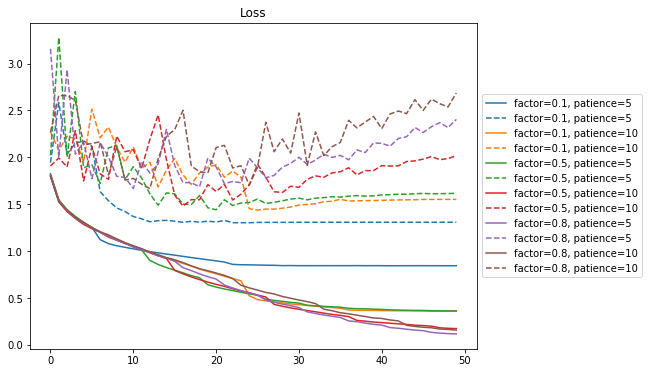

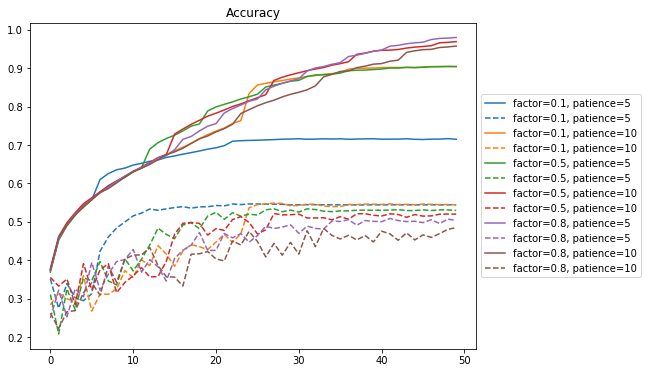

In [69]:
# 繪製結果
plt.figure(figsize=(8,6))
for i, cond in enumerate(results_rmsprop.keys()):
    plt.plot(range(len(results_rmsprop[cond]['train-loss'])),results_rmsprop[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_rmsprop[cond]['valid-loss'])),results_rmsprop[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_rmsprop.keys()):
    plt.plot(range(len(results_rmsprop[cond]['train-acc'])),results_rmsprop[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_rmsprop[cond]['valid-acc'])),results_rmsprop[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()